<a href="https://www.kaggle.com/code/honganzhu/cmicomp?scriptVersionId=200546574" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
import lightgbm as lgb
from colorama import Fore, Style
from scipy.optimize import minimize
import os

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score, ConfusionMatrixDisplay, confusion_matrix

import re
from sklearn.base import clone
import ydf
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Import libraries

In [4]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [5]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train
test

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""00c0cd71""","""Winter""",7,0,"""Summer""",51,"""Spring""",29.315775,54.0,121.6,null,80,75,99,"""Spring""",4,5,32,"""Spring""",6,1,null,null,null,null,0,0,12.0,1,15.0,1,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",35,50,"""Winter""",2
"""00d56d4b""","""Spring""",5,1,"""Summer""",80,"""Spring""",17.284504,44.0,47.6,null,61,76,109,"""Spring""",null,null,null,"""Spring""",0,0,null,null,null,null,0,0,10.5,1,10.0,1,7.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",37,53,"""Spring""",0
"""00d9913d""","""Fall""",10,1,null,null,"""Fall""",19.893157,55.0,85.6,30.0,null,81,null,null,null,null,null,"""Fall""",5,0,null,null,null,null,0,0,0.0,0,0.0,0,9.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",1


For a supervised learning, we need the target value, but some (sii) are missing. So we only use the part with valid target value(sii).

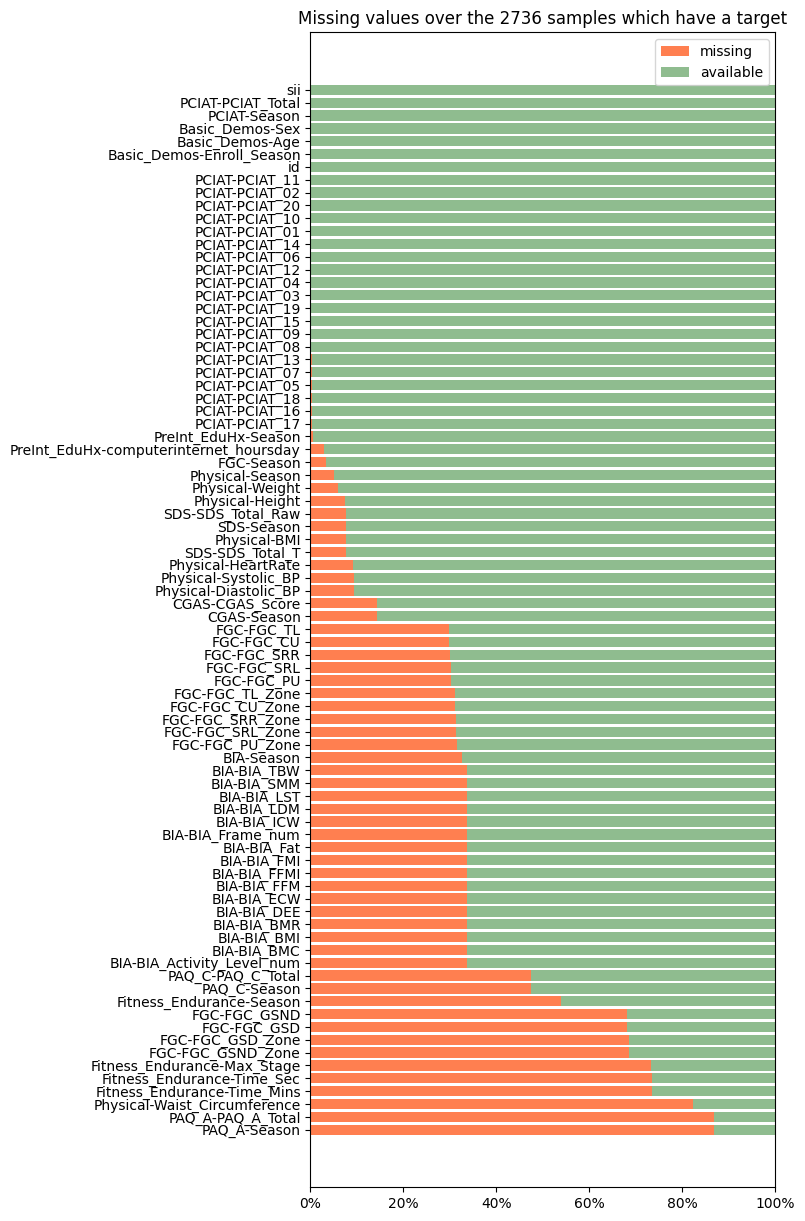

In [6]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

In [7]:
print(train.select(pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null()).to_series().mean())

(train
 .select(pl.col('PCIAT-PCIAT_Total'))
 .group_by(train.get_column('sii'))
 .agg(pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),
      pl.col('PCIAT-PCIAT_Total').len().alias('count'))
 .sort('sii')
)

1.0


sii,PCIAT-PCIAT_Total min,PCIAT-PCIAT_Total max,count
i64,i64,i64,u32
null,null,null,1224
0,0,30,1594
1,31,49,730
2,50,79,378
3,80,93,34


**Insight:**

This dataset is imbalanced. Half of the samples are in class 0, while very few in class 3.


In [8]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


# Demographics


Now we look at some basic demographics.

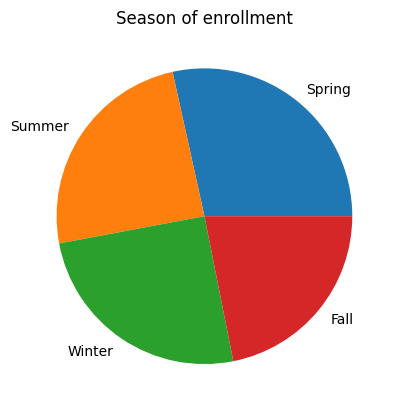

In [9]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

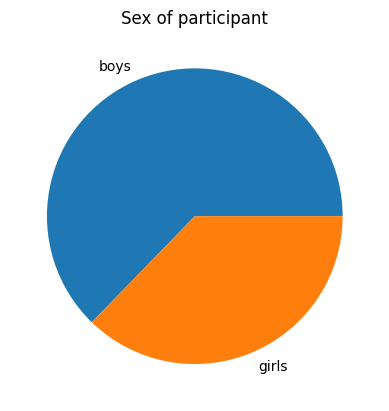

In [10]:
vc = train.get_column('Basic_Demos-Sex').value_counts()
plt.pie(vc.get_column('count'), labels=['boys', 'girls'])
plt.title('Sex of participant')
plt.show()

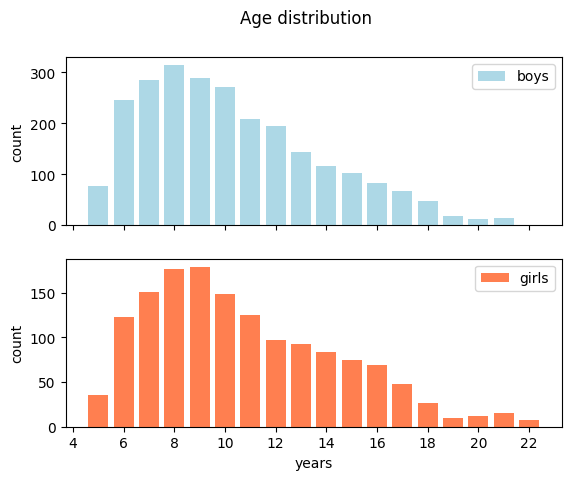

In [11]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

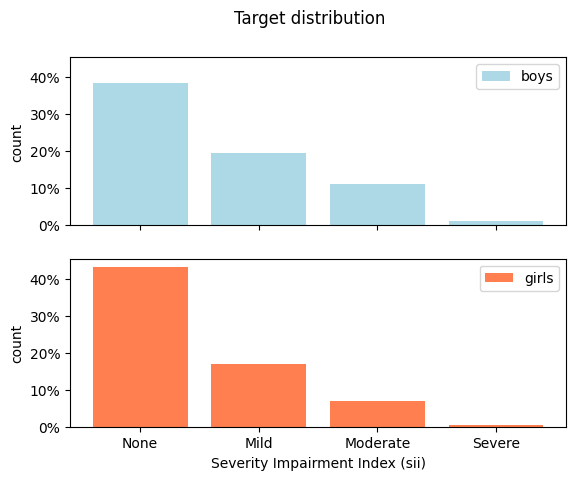

In [12]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

# Now we look at correlations

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
Physical-Systolic_BP                      0.147081
PreInt_EduHx-computerinternet_hoursday    0.374124
SDS-SDS_Total_T                           0.237718
FGC-FGC_CU                                0.287494
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_PU                                0.196006
FGC-FGC_TL                                0.136696
BIA-BIA_BMI                               0.248060
BIA-BIA_FFMI                              0.109694
BIA-BIA_Frame_num                         0.193631
Name: PCIAT-PCIAT_Total, dtype: float64


<Figure size 1400x1200 with 0 Axes>

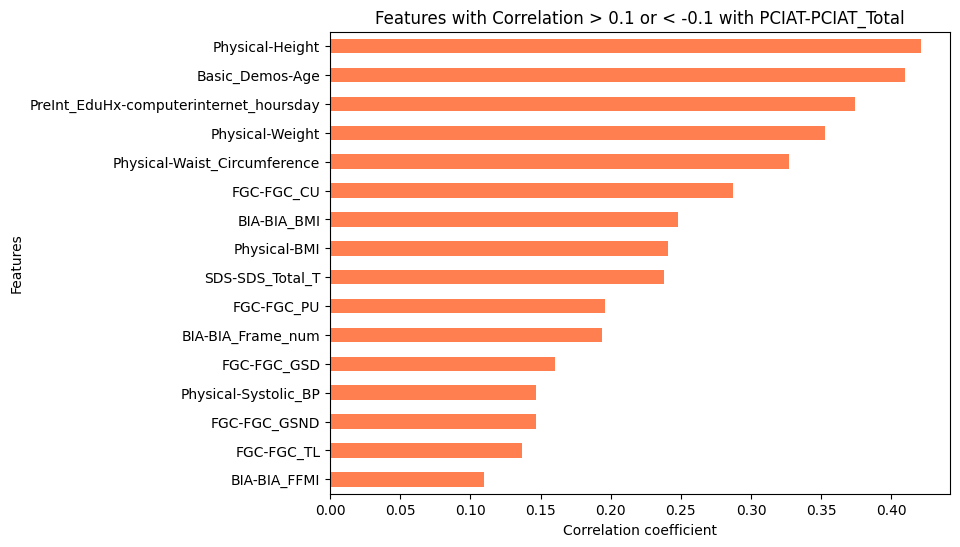

In [13]:
plt.figure(figsize=(14, 12))
corr_matrix = supervised_usable.select([
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI','BIA-BIA_FMI', 'BIA-BIA_Fat','BIA-BIA_Frame_num','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST',
    'BIA-BIA_SMM','BIA-BIA_TBW'
    # Add other relevant columns
]).to_pandas().corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

print(filtered_corr)

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

# Actigraphy (time series)

In [14]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…
287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.0,3695.0,32875000000000,1,3,53.0
287175,-0.703572,0.016187,0.15956,0.03598,14.12139,0.0,7.0,3695.0,32880000000000,1,3,53.0
287176,-0.209607,-0.4697,0.636573,0.097799,44.998573,0.0,7.0,3695.0,32885000000000,1,3,53.0


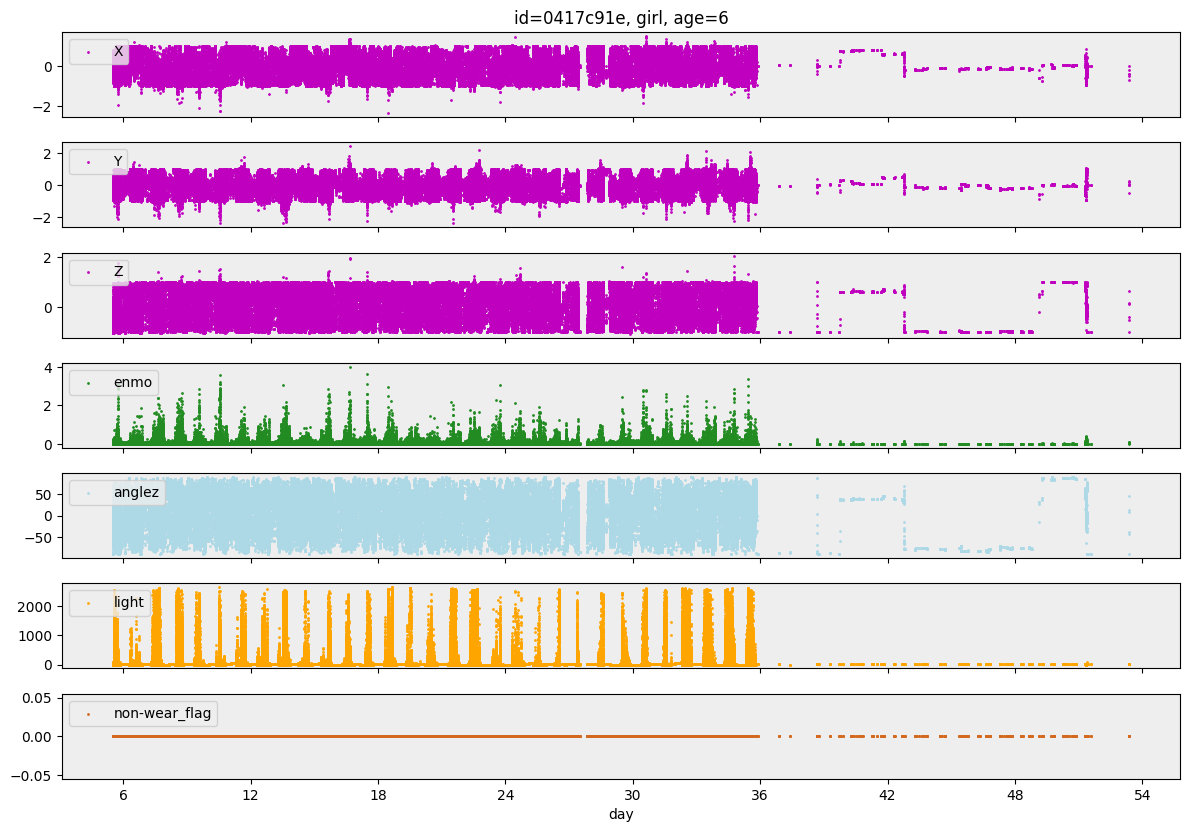

In [15]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

# Classification

We try to run classification models on all the features.

In [16]:
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

kf = StratifiedKFold(shuffle=True, random_state=1)
oof = np.zeros(len(y), dtype=int)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]
    
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred
    
score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (classification with LightGBM){Style.RESET_ALL}")

# Fold 0: score=0.354
# Fold 1: score=0.350
# Fold 2: score=0.256
# Fold 3: score=0.317
# Fold 4: score=0.379
# Overall: score=0.331 (classification with LightGBM)


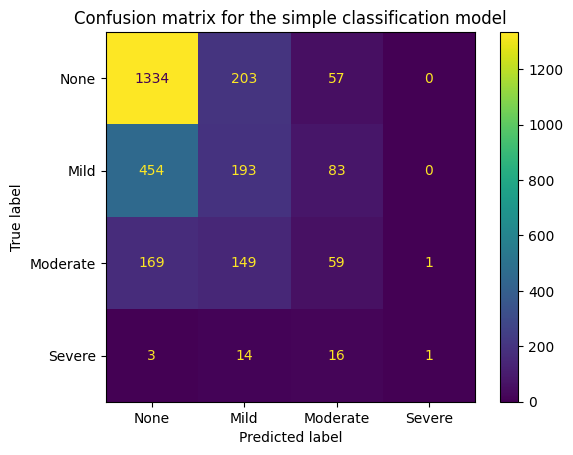

In [17]:
ConfusionMatrixDisplay.from_predictions(y, oof)
plt.title('Confusion matrix for the simple classification model')
plt.xticks(np.arange(4), target_labels)
plt.yticks(np.arange(4), target_labels)
plt.show()

# Regression

In [18]:
y = supervised_usable.get_column('PCIAT-PCIAT_Total')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

model = None

kf = KFold(shuffle=True, random_state=1)
oof_raw = np.zeros(len(y), dtype=float) # oof predictions, before rounding
oof = np.zeros(len(y), dtype=int) # oof predictions, rounded
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]

    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(X_tr, y_tr.to_numpy())
    y_pred = model.predict(X_va)
    oof_raw[idx_va] = y_pred
    y_pred = y_pred.round(0).astype(int)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred

score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (regression with LightGBM){Style.RESET_ALL}")

# Fold 0: score=0.441
# Fold 1: score=0.402
# Fold 2: score=0.466
# Fold 3: score=0.456
# Fold 4: score=0.452
# Overall: score=0.441 (regression with LightGBM)


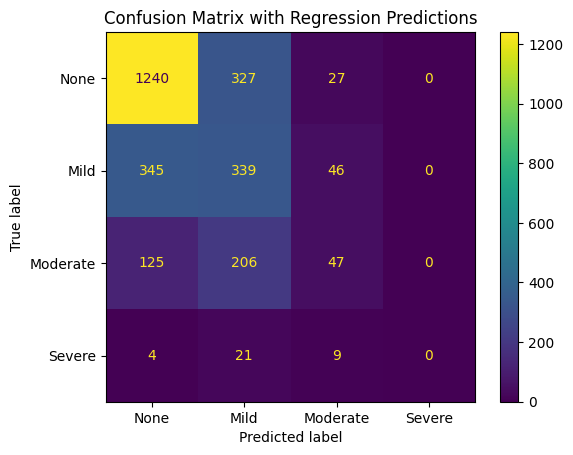

In [19]:
def map_to_labels(values):
    labels = np.zeros_like(values, dtype=int)
    labels[(values >= 0) & (values <= 30)] = 0  # None
    labels[(values >= 31) & (values <= 49)] = 1  # Mild
    labels[(values >= 50) & (values <= 79)] = 2  # Moderate
    labels[(values >= 80) & (values <= 100)] = 3  # Severe
    return labels

# Step 1: Convert both y (true values) and oof (predicted values) into categories
y_labels = map_to_labels(y)
oof_labels = map_to_labels(oof_raw)

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(y_labels, oof_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot()

# Optional: Add title or other customization if needed
plt.title('Confusion Matrix with Regression Predictions')
plt.show()

# Decision Forests

In [20]:
X = supervised_usable.drop('id', '^PCIAT.*$').to_pandas()

selected_features = [
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'Physical-Waist_Circumference', 'Physical-Systolic_BP',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'FGC-FGC_CU',
    'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_TL', 
    'BIA-BIA_BMI', 'BIA-BIA_FFMI', 'BIA-BIA_Frame_num'
]

model_GBT = ydf.GradientBoostedTreesLearner(label="sii").train(X)

max_vocab_count = -1 for column sii, the dictionary will not be pruned by size.


Train model on 2736 examples


"goss_alpha" set but "sampling_method" not equal to "GOSS".
"goss_beta" set but "sampling_method" not equal to "GOSS".
"selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
Data spec:
Number of records: 2736
Number of columns: 59

Number of columns by type:
	NUMERICAL: 48 (81.3559%)
	CATEGORICAL: 11 (18.6441%)

Columns:

NUMERICAL: 48 (81.3559%)
	2: "Basic_Demos-Age" NUMERICAL mean:10.2387 min:5 max:22 sd:3.42736 dtype:DTYPE_INT64
	3: "Basic_Demos-Sex" NUMERICAL mean:0.364401 min:0 max:1 sd:0.481262 dtype:DTYPE_INT64
	5: "CGAS-CGAS_Score" NUMERICAL num-nas:394 (14.4006%) mean:65.1593 min:25 max:95 sd:11.8085 dtype:DTYPE_FLOAT64
	7: "Physical-BMI" NUMERICAL num-nas:209 (7.63889%) mean:19.1257 min:0 max:46.1029 sd:4.90833 dtype:DTYPE_FLOAT64
	8: "Physical-Height" NUMERICAL num-nas:206 (7.52924%) mean:55.8971 min:36 max:78.5 sd:7.39348 dtype:DTYPE_FLOAT64
	9: "Physical-Weight" NUMERICAL num-nas:164 (5.99415%) mean:87.8396 min:0 max:315 sd:43.3447 dtype:DTYPE_

Model trained in 0:00:02.416949


Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.912128
Truncates the model to 148 tree(s) i.e. 37  iteration(s).
Final model num-trees:37 valid-loss:0.912128 valid-accuracy:0.587302


In [21]:
model_GBT.describe()

In [22]:
evaluation_GBT = model_GBT.evaluate(X)
evaluation_GBT

Model loaded with 148 root(s), 6030 node(s), and 58 input feature(s).
Engine "GradientBoostedTreesGeneric" built


Label \ Pred,0,1,2,3
0,1551,209,82,0
1,33,502,40,1
2,10,19,256,0
3,0,0,0,33


In [23]:
model_RF = ydf.RandomForestLearner(label="sii").train(X)

Train model on 2736 examples


max_vocab_count = -1 for column sii, the dictionary will not be pruned by size.
Data spec:
Number of records: 2736
Number of columns: 59

Number of columns by type:
	NUMERICAL: 48 (81.3559%)
	CATEGORICAL: 11 (18.6441%)

Columns:

NUMERICAL: 48 (81.3559%)
	2: "Basic_Demos-Age" NUMERICAL mean:10.2387 min:5 max:22 sd:3.42736 dtype:DTYPE_INT64
	3: "Basic_Demos-Sex" NUMERICAL mean:0.364401 min:0 max:1 sd:0.481262 dtype:DTYPE_INT64
	5: "CGAS-CGAS_Score" NUMERICAL num-nas:394 (14.4006%) mean:65.1593 min:25 max:95 sd:11.8085 dtype:DTYPE_FLOAT64
	7: "Physical-BMI" NUMERICAL num-nas:209 (7.63889%) mean:19.1257 min:0 max:46.1029 sd:4.90833 dtype:DTYPE_FLOAT64
	8: "Physical-Height" NUMERICAL num-nas:206 (7.52924%) mean:55.8971 min:36 max:78.5 sd:7.39348 dtype:DTYPE_FLOAT64
	9: "Physical-Weight" NUMERICAL num-nas:164 (5.99415%) mean:87.8396 min:0 max:315 sd:43.3447 dtype:DTYPE_FLOAT64
	10: "Physical-Waist_Circumference" NUMERICAL num-nas:2253 (82.3465%) mean:26.6253 min:19 max:50 sd:5.2248 dtype:DT

Model trained in 0:00:01.890967


In [24]:
model_RF.describe()

In [25]:
evaluation_RF = model_RF.evaluate(X)
evaluation_RF

Model loaded with 300 root(s), 175854 node(s), and 58 input feature(s).


Label \ Pred,0,1,2,3
0,1594,111,91,4
1,0,619,2,12
2,0,0,285,3
3,0,0,0,15


In [26]:
#test_X = test.drop('id').with_columns(pl.lit(0).alias('sii')).to_pandas()
test_X = test.drop('id').to_pandas()

In [27]:
def prediction_to_kaggle_format(model, test_X):
    #sii_level = model.predict(test_X)
    #predicted_classes = np.argmax(sii_level, axis=1)
    test_predictions = model.predict(test_X)
    predicted_classes = map_to_labels(test_predictions)
    print(predicted_classes)
    return pd.DataFrame({
        "id": test["id"],
        "sii": predicted_classes
    })

def make_submission(kaggle_predictions):
    path="/kaggle/working/submission.csv"
    kaggle_predictions.to_csv(path, index=False)
    print(f"Submission exported to {path}")
    
#kaggle_predictions = prediction_to_kaggle_format(model,test_X)
#make_submission(kaggle_predictions)
#!head /kaggle/working/submission.csv

# LGB, XGB, Catboost, and Ensemble

In [4]:
SEED = 42
n_splits = 5

In [5]:
# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [6]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [7]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   


featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday','sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')


cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


In [8]:
def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

In [9]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday']

featuresCols += time_series_cols

In [10]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)



for f in featuresCols:
    f_mode = train[f].mode()[0]  # Calculate the mode of the column
    train.loc[:, f] = train[f].fillna(f_mode)  # Fill missing values in the training set with the mode
    test.loc[:, f] = test[f].fillna(f_mode)  # Fill missing values in the test set with the mode

In [11]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [12]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

In [13]:

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'gpu'

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'

}

In [14]:
# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=200)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

In [15]:
# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])



# Train the ensemble model
Submission = TrainML(voting_model, test)

# Save submission
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())
print(Submission)

Training Folds: 100%|██████████| 5/5 [01:02<00:00, 12.53s/it]

Mean Train QWK --> 0.7304
Mean Validation QWK ---> 0.3844


----> || Optimized QWK SCORE ::  0.462
sii
0    12
1     6
2     2
Name: count, dtype: int64
          id  sii
0   00008ff9    1
1   000fd460    0
2   00105258    0
3   00115b9f    0
4   0016bb22    0
5   001f3379    1
6   0038ba98    0
7   0068a485    0
8   0069fbed    2
9   0083e397    0
10  0087dd65    0
11  00abe655    0
12  00ae59c9    2
13  00af6387    1
14  00bd4359    1
15  00c0cd71    1
16  00d56d4b    0
17  00d9913d    0
18  00e6167c    0
19  00ebc35d    1
